## Executing the ARC challenges with Gemma2-9B-it

First download the challenges from:
- https://github.com/fchollet/ARC-AGI

This work uses the training set.
- https://github.com/fchollet/ARC-AGI/tree/master/data/training

The Together.ai api is used for Gemma2-9B-it, all 400 challenges can be completed for < $3.
An api key is required.

In [1]:
# load challenge data from the file
import os

# set working directory
os.chdir("/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/MechInterp")
cwd = os.getcwd()
print(cwd)
.6
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(usecwd=True))
TOGETHER_API_KEY = os.getenv('TOGETHER_API_KEY')

/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/MechInterp


## Data Exploration

Get a list of challenge files in the folder and visualise hand picked examples

In [6]:
# get list of all files from folder

def get_json_files(folder_path):
    json_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            json_files.append(filename)
    return json_files

In [7]:
import json
import pprint
import numpy as np

def get_train_for_visualisation(filename: str):

    with open('/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/' + filename, 'r') as file:
        dataset = json.load(file)

    train_len = len(dataset['train'])

    array_inputs  = []
    array_outputs = []

    for pair in range(train_len):
        train_input  = np.array(dataset['train'][pair]['input'])
        train_output = np.array(dataset['train'][pair]['output'])

        array_inputs.append(train_input)
        array_outputs.append(train_output)

    # add test data
    test_input  = np.array(dataset['test'][0]['input'])
    test_output = np.array(dataset['test'][0]['output'])

    array_inputs.append(test_input)
    array_outputs.append(test_output)

    return array_inputs, array_outputs

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def visualize_matrices(matrix1, matrix2, title1='input', title2='output'):
    # Define a fixed color scheme for integers 0-9
    colors = ['#FFFFFF', '#FF0000', '#00FF00', '#0000FF', '#FFFF00', 
              '#FF00FF', '#00FFFF', '#FFA500', '#800080', '#008000']
    color_map = ListedColormap(colors)

    # Create a new figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    
    # Function to plot a single matrix
    def plot_matrix(ax, matrix, title):
        # Remove axes ticks
        ax.set_xticks(np.arange(-.5, matrix.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, matrix.shape[0], 1), minor=True)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Plot the matrix
        im = ax.imshow(matrix, cmap=color_map, vmin=0, vmax=9, interpolation='nearest')
        
        # Add gridlines
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        
        # Add text for non-zero values
        for (j, i), value in np.ndenumerate(matrix):
            if value != 0:
                ax.text(i, j, str(value), ha='center', va='center', 
                        color='black', fontweight='bold')
        
        ax.set_title(title, color='white')
    
    # Plot both matrices
    plot_matrix(ax1, matrix1, title1)
    plot_matrix(ax2, matrix2, title2)
    
    plt.tight_layout()
    plt.show()


Training file: 7f4411dc.json
Training inputs + outputs
Pair: 1


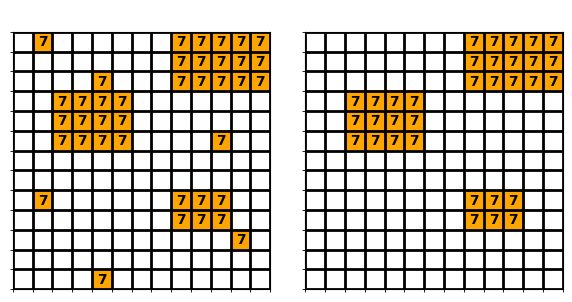

Pair: 2


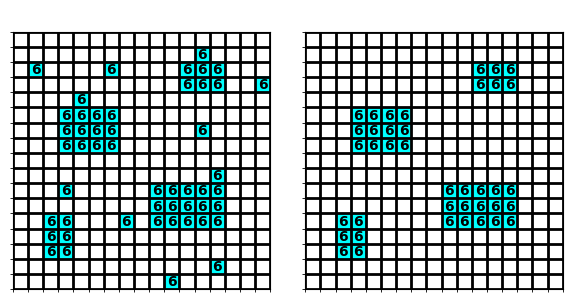

Pair: 3


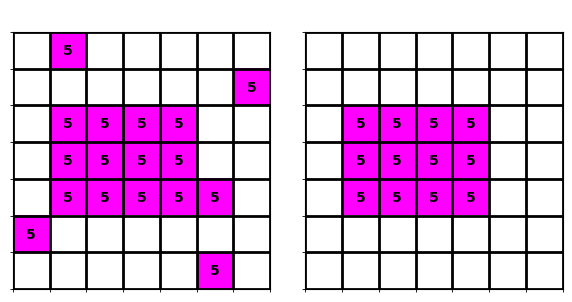

Test input + output


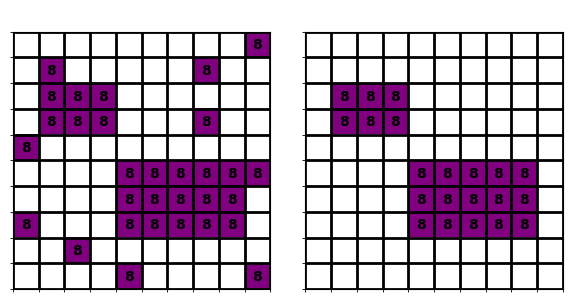

In [10]:
hand_picked_examples = [
    #'3c9b0459.json',
    '7f4411dc.json',
    #'f8ff0b80.json'
]

for filename in hand_picked_examples:
    print("\n===========")
    print(f"Training file: {filename}")
    inputs, outputs = get_train_for_visualisation(filename)
    length = len(inputs)
    for i, pair in enumerate(zip(inputs, outputs)):
        if i == 0:
            print("Training inputs + outputs")
        if i <length-1:
            print(f"Pair: {i+1}")
        if i == length-1:
            print("Test input + output")
        visualize_matrices(pair[0], pair[1])

### Functions to convert the challenges into text for a prompt

In [4]:
import numpy as np
import json
import pprint
from typing import List, Dict, Any

# convert training data of an individual challenge to a prompt.
def get_train(filename: str):
    result = []
    with open('/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/' + filename, 'r') as file:
        dataset = json.load(file)

    train_len = len(dataset['train'])

    for pair in range(train_len):
        array_input  = np.array(dataset['train'][pair]['input'])
        array_output = np.array(dataset['train'][pair]['output'])

        result.append("=============") if pair > 0 else None
        result.append(f"TRAIN Pair {pair}")
        result.append(f"INPUT. Shape={array_input.shape}")
        result.append(pprint.pformat(array_input))
        result.append(f"OUTPUT. Shape={array_output.shape}")
        result.append(pprint.pformat(array_output))

    test_actual = np.array(dataset['test'][0]['input'])
    result.append("=============")
    result.append(f"TEST Pair 0")
    result.append(f"INPUT. Shape={test_actual.shape}")
    result.append(pprint.pformat(test_actual))
    result.append('OUTPUT. ')

    return '\n'.join(result)

# convert test data of an individual challenge to a prompt.
def get_test_outcome(filename: str):
    result = []
    with open('/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/' + filename, 'r') as file:
        dataset = json.load(file)

    test_actual = np.array(dataset['test'][0]['output'])
    # result.append("=============")
    # result.append(f"TARGET OUTPUT")
    result.append(f"OUTPUT. Shape={test_actual.shape}")
    result.append(pprint.pformat(test_actual))
 
    return test_actual, '\n'.join(result)

In [5]:

folder_path = '/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/'
all_files      = get_json_files(folder_path)
print(f"All challenges: {len(all_files)}")


All challenges: 403


### Prompts, Long and Short

In [6]:
instructions_long = """# PROJECT INSTRUCTIONS

The training data consists of pairs of input and output grids, presented as numpy arrays of varying shapes.
Your task is to discover the single mapping which converts each input grid to its corresponding output grid and apply that to the test input, arriving at a test output.

## 1. OBSERVE AND HYPOTHESISE THE MAPPING LOGIC FOR ALL TRAINING PAIRS

When building your hypotheses on the mappings, be aware of the following common transformations:

    Grid Expansion and Repetition (Tiling):
    - Simply expand the grid and repeat (tile) the input grid into the output grid
    Symmetry and Mirroring (flipping):
    - Horizontally or vertically
    Propagation of patterns:
    - Identify non-zero clusters or shapes in the input grid and propagating them in the output. Proceeding horizontally, vertically or diagonally.
    Mathematical Operations:
    - Incrementing values, taking modulo, or performing addition.
    Color/Value Substitution:
    - Values in the input grid replaced with different values in the output grid, often changing all instances of one number to another
    Shape Detection and Transformation:
    - Identifying geometric shapes in the input grid and applying transformations such as rotation, scaling, flipping, translation and/or overlapping.
    Grid Segmentation:
    - Divide the input grid into sections and apply transformations to each section.
    Boundary Detection and Fill:
    - Identify the boundaries of shapes or patterns and fill them with specific values. This sometimes involved propagating values from the edges inward.
    Connectivity-based Transformations:
    - Using connected component analysis to identify and transform groups of connected cells.
    Rule-based Transformations:
    - Applying specific rules based on the arrangement of values in the input grid. These rules often considered the neighboring cells of each position.
    Coordinate-based Transformations:
    - Using the coordinates of cells to determine how they should be transformed or moved in the output grid.
    When the pattern is more complex than originally assumed:
    - Review all training pairs again and try to describe the transformation in plain language

Use these patterns to guide your own hypotheses on the training data.

## 2. PREDICT THE OUTPUT GRID FOR THE TEST INPUT GRID

Having considered the data...
FIRST score your confidence that you understand the mapping pattern, 0-5 where 0 is zero is no confidence and 5 is highly confident. 
This score must be the FIRST output you give, no preamble, no prefix, no punctuation, just a single digit score.
THEN Present your predicted output in np.array format

## 3. THE DATA
"""

In [7]:
instructions_short = """Below are pairs of matrices. 
There is a mapping which operates on each input to give the output, only one mapping applies to all matrices. 
Review the matrices to learn that mapping and then estimate the missing output for the final input matrix.

FIRST score your confidence that you understand the mapping pattern, 0-5 where 0 is zero is no confidence and 5 is highly confident. 
This score must be the FIRST output you give, no preamble, no prefix, no punctuation, just a single digit score.
THEN Present your predicted output in np.array format
"""


### Helper Functions

a) To extract predicted matrix from the LLM's response. 
- On larger models we may demand a json response (aka 'function calling' or 'structured response') but this is not available for Gemma2.

b) Get the first token, which is the model's confidence score

c) Calculate similarity of the prediction with the target

In [8]:
import re
import ast

def extract_and_convert_matrix(output):
    # Extract matrix string
    matrix_str = re.findall(r'\[(?:\[(?:\d+,?\s*)+\],?\s*)+\]', output)

    if not matrix_str or len(matrix_str[-1]) <= 2:
        return np.array([[0]])  # Return a default matrix if no valid matrix is found

    # Get the final instance of matrix in the text
    matrix_str = matrix_str[-1]
    # Replace newlines with commas when not prefixed with commas
    matrix_str = re.sub(r'\]\s*\n\s*\[', '], [', matrix_str)
    # Remove any remaining whitespace
    matrix_str = re.sub(r'\s', '', matrix_str)

    try:
        # Use ast.literal_eval for safe evaluation
        matrix_list = ast.literal_eval(matrix_str)

        # Check if the matrix is regular (all rows have the same length)
        if all(len(row) == len(matrix_list[0]) for row in matrix_list):
            return np.array(matrix_list)
        else:
            # If irregular, pad shorter rows with zeros
            max_length = max(len(row) for row in matrix_list)
            padded_matrix = [row + [0] * (max_length - len(row)) for row in matrix_list]
            return np.array(padded_matrix)

    except Exception as e:
        print(f"Error converting matrix: {e}")
        print(f"Problematic matrix string: {matrix_str}")
        return np.array([-1])  # Return a default matrix in case of conversion error

def get_first_token(text):
    match = re.match(r'(\w+|\d+)', text)
    first = False
    if match:
        first = match.group(1).lower()
    return first

def element_similarity(a, b):
    if a == b:
        return 1.0  # Same value, perfect similarity
    elif abs(a - b) == 1:
        return 0.5  # Difference of 1, partial similarity
    else:
        return 0  # Larger difference, no similarity

def matrix_similarity(matrix1, matrix2):
    
    if not isinstance(matrix1, np.ndarray) or not isinstance(matrix2, np.ndarray):
        return -2

    if matrix1.shape != matrix2.shape:
        return -1
    
    total_elements = matrix1.size
    similarity_sum = sum(element_similarity(a, b) for a, b in zip(matrix1.flatten(), matrix2.flatten()))
    
    return similarity_sum / total_elements

### Function make calls to Together.ai

In [9]:
from together import Together

def arc_agent_together(model, filename, temp, prompt_text, confidence_measures=['0', '1','2','3','4','5']):

    training_data = get_train(filename)

    prompt = prompt_text+training_data

    # call the agent
    client = Together(api_key=TOGETHER_API_KEY)

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
        )
        output = response.choices[0].message.content

        # consumption
        consumption = {
            'function': 'arc_agent',
            'model': response.model,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens
        }

        # get confidence measure
        first_token = get_first_token(output)
        if first_token not in confidence_measures:
            print(f"not in confidence measures: {first_token}")
            first_token = 'False' # intentionally a string.

        output_extracted = extract_and_convert_matrix(output)

    except Exception as e:
        if "Input validation error: `inputs` tokens + `max_new_tokens` must be <=" in str(e):
            print(f"Caught: {e}")
            output = "[-2]"
            output_extracted = np.array([-2])
            first_token = 'ERROR'
            consumption = {
                'function': 'arc_agent',
                'model': model,
                'input_tokens': 0,
                'output_tokens': 0
            }
        else:
            # Re-raise the exception if it's not the specific error we're looking for
            output = "[-3]"
            output_extracted = np.array([-3])
            first_token = 'ERROR'
            consumption = {
                'function': 'arc_agent',
                'model': model,
                'input_tokens': 0,
                'output_tokens': 0
            }
            raise

    return prompt_text, output, output_extracted, consumption, first_token

In [10]:
# Test call to Together
filename_test = 'd4469b4b.json'

prompt, output, output_extracted, consumption, first_token = arc_agent_together('google/gemma-2-9b-it', filename_test, temp=0, prompt_text=instructions_short)

print("======")
print(first_token)
print("======")
print(output)
test_actual, test_outcome_print = get_test_outcome(filename_test) #d4469b4b
print(test_outcome_print)

4
4
np.array([[0, 5, 0],
       [5, 5, 5],
       [0, 5, 0]]) 

OUTPUT. Shape=(3, 3)
array([[0, 5, 0],
       [5, 5, 5],
       [0, 5, 0]])


### Loop Over All Files

a) Function to make call to together.ai for each challenge and extract the response.
b) Fucntion to execute asynchronously, as we have 400 files to review

In [29]:
import pandas as pd
import numpy as np

def execute_predictions(files_list, num_executions, model, temp=0.0, vary_temp=False, prompt_text=instructions_long):
    
    df = None
    temp_start = temp

    for execution in range(num_executions):
        print(f"Execution {execution+1} of {num_executions}. Temp={temp}")
        results = []
        for i in range(len(files_list)):
            print(f"{i}: {files_list[i]}")
            prompt, prediction, prediction_extracted, consumption, first_token = arc_agent_together(model, files_list[i], temp, prompt_text)
            target, _ = get_test_outcome(files_list[i])

            if prediction_extracted.shape == target.shape:
                outcome = prediction_extracted == target
            else:
                outcome = np.array([False])
            # print(outcome.all())
            
            similarity = matrix_similarity(prediction_extracted, target)

            row = {
                'filename': files_list[i],
                'prompt_len': len(prompt_text),
                'first_token': first_token,
                'prediction_extracted': str(prediction_extracted.tolist()),
                'target': str(target.tolist()),
                'similarity': similarity,
                'outcome': outcome.all(),
            }
            results.append(row)

        new_df = pd.DataFrame(results)
        
        if df is None:
            df = new_df
        else:
            df[f'outcome_{execution}_temp_{temp}'] = new_df['outcome']

        if vary_temp:
            temp = temp_start + ((0.9-temp_start)/num_executions)*(execution+1)

    return df

In [32]:
import asyncio
import pandas as pd
from functools import partial

async def async_execute_predictions(semaphore, task_id, all_files, num_executions, model, temp, vary_temp, prompt_text):
    async with semaphore:
        df_results = await asyncio.to_thread(
            execute_predictions,
            all_files,
            num_executions=num_executions,
            model=model,
            temp=temp,
            vary_temp=vary_temp,
            prompt_text=prompt_text
        )
        # Add a column to indicate which task this result came from
        df_results['task_id'] = task_id
        return task_id, df_results

async def main(task_list, concurrent_tasks=5):
    semaphore = asyncio.Semaphore(concurrent_tasks)  # Limit to 3 concurrent operations
    tasks = []
    
    for task_id, task_params in enumerate(task_list):
        task = async_execute_predictions(
            semaphore,
            task_id,
            all_files=task_params.get('all_files'),
            num_executions=task_params.get('num_executions', 1),
            model=task_params.get('model', 'google/gemma-2-9b-it'),
            temp=task_params.get('temp', 0),
            vary_temp=task_params.get('vary_temp', False),
            prompt_text=task_params.get('prompt_text', instructions_long)
        )
        tasks.append(task)
    
    results = await asyncio.gather(*tasks)
    
    # Extract dataframes from tuples and concatenate vertically
    dataframes = [df for _, df in sorted(results, key=lambda x: x[0])]
    df_combined = pd.concat(dataframes, axis=0, ignore_index=True)
    
    # Ensure 'task_id' is the first column
    columns = ['task_id'] + [col for col in df_combined.columns if col != 'task_id']
    df_combined = df_combined[columns]
    
    return df_combined

## Execute

Execute the calls for both the short prompt and the long prompt
Do this 5x for each challenge. Can opt to change temp, or confirm variance when temp=0.
These 5 iterations will run as concurrent tasks

In [ ]:
# Define list of tasks for short prompt
task_list = [
    {'all_files': all_files, 'prompt_text': instructions_short},
    {'all_files': all_files, 'prompt_text': instructions_short},
    {'all_files': all_files, 'prompt_text': instructions_short},
    {'all_files': all_files, 'prompt_text': instructions_short},
    {'all_files': all_files, 'prompt_text': instructions_short},
]

# For Jupyter notebooks, use this to run the main function
df_combined1 = await main(task_list, concurrent_tasks=5)

# save results
df_combined1.to_parquet("df_combined_short")


In [ ]:
# Define list of tasks for short prompt

# Define your list of tasks
task_list = [
    {'all_files': all_files, 'prompt_text': instructions_long},
    {'all_files': all_files, 'prompt_text': instructions_long},
    {'all_files': all_files, 'prompt_text': instructions_long},
    {'all_files': all_files, 'prompt_text': instructions_long},
    {'all_files': all_files, 'prompt_text': instructions_long},
]

# For Jupyter notebooks, use this to run the main function
df_combined2 = await main(task_list, concurrent_tasks=5)

# save results
df_combined2.to_parquet("df_combined_long")

In [35]:
# combine the data
df_combined = pd.concat([df_combined1, df_combined2], axis=0, ignore_index=True)

# save the combined results in format easy for manual inspection
df_combined.to_excel("gemma2.xlsx")

## Does Confidence Correlate with Performance?

The LLM is requested to provide a confidence score 0-5 (higher is more confident) for their pending performance on each challenge.
Does this correlate with actual performance?

In [3]:
import pandas as pd
df_combined = pd.read_excel("gemma2.xlsx")

/tmp/ipykernel_247426/2077496820.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['first_token'] = pd.to_numeric(df_cleaned['first_token'])


Spearman's rank correlation coefficient: 0.0110
P-value: 0.5454
Kendall's tau-b: 0.0092
P-value (Kendall's tau-b): 0.5299


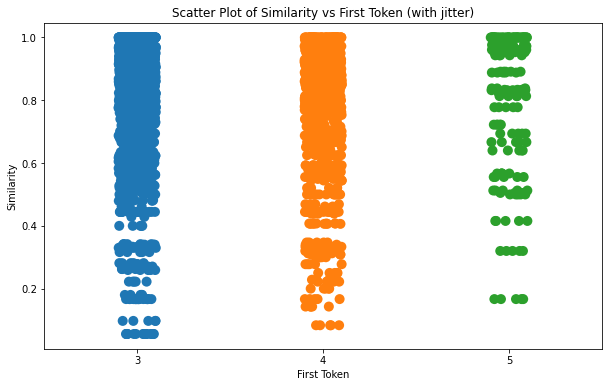

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Remove rows where similarity is -1 or first_token is ERROR
df_cleaned = df_combined[(df_combined['similarity'] > 0) & (df_combined['first_token'] != 'ERROR')]

# Convert first_token to numeric
df_cleaned['first_token'] = pd.to_numeric(df_cleaned['first_token'])


# Statistical Test: Spearman's rank correlation
spearman_corr, p_value = stats.spearmanr(df_cleaned['first_token'], df_cleaned['similarity'])

print(f"Spearman's rank correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Effect Size: Kendall's tau-b
tau_b, p_value_tau = stats.kendalltau(df_cleaned['first_token'], df_cleaned['similarity'])

print(f"Kendall's tau-b: {tau_b:.4f}")
print(f"P-value (Kendall's tau-b): {p_value_tau:.4f}")

# Additional Visualization: Scatter plot with jitter
plt.figure(figsize=(10, 6))
sns.stripplot(x='first_token', y='similarity', data=df_cleaned, jitter=True, size=10)
plt.title('Scatter Plot of Similarity vs First Token (with jitter)')
plt.xlabel('First Token')
plt.ylabel('Similarity')
plt.show()

## How well is Confidence=5 aligned with Similarity?

It appears that only a confidence score of 5 gives us any information about actual performance.
Let's run some more statisstical tests.

In [5]:
df_cleaned

,Unnamed: 0,task_id,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome
1,1,0,aabf363d.json,550,5,"[[0, 0, 0, 0, 0, 0, 0], [0, 16, 16, 16, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 2, 0, 0, 0],...",0.693878,False
2,2,0,0ca9ddb6.json,550,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ...",0.851852,False
4,4,0,6150a2bd.json,550,4,"[[0, 0, 6], [0, 8, 6], [5, 3, 4]]","[[0, 0, 4], [0, 8, 6], [5, 3, 6]]",0.777778,False
5,5,0,445eab21.json,550,4,"[[3, 9], [9, 9]]","[[3, 3], [3, 3]]",0.250000,False
7,7,0,913fb3ed.json,550,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.916016,False
...,...,...,...,...,...,...,...,...,...
4024,4024,4,508bd3b6.json,2693,3,"[[0, 0, 0, 3, 0, 0, 0, 0, 2, 2, 2, 2], [0, 0, ...","[[0, 0, 0, 8, 0, 0, 0, 0, 2, 2, 2, 2], [0, 0, ...",0.916667,False
4025,4025,4,d2abd087.json,2693,3,"[[0, 2, 2, 0, 0, 0, 2, 2, 0, 0], [0, 2, 2, 0, ...","[[0, 1, 1, 0, 0, 0, 2, 2, 0, 0], [0, 1, 1, 0, ...",0.915000,False
4026,4026,4,00d62c1b.json,2693,3,"[[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.725000,False
4027,4027,4,08ed6ac7.json,2693,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, ...",0.876543,False


              count      mean       std       min       25%       50%  \
first_token                                                             
3            1646.0  0.778046  0.208126  0.055556  0.669753  0.840000   
4            1193.0  0.775764  0.205729  0.083333  0.679012  0.850000   
5             165.0  0.785369  0.228295  0.166667  0.640000  0.837778   

                  75%  max  
first_token                 
3            0.928571  1.0  
4            0.920000  1.0  
5            0.979167  1.0  


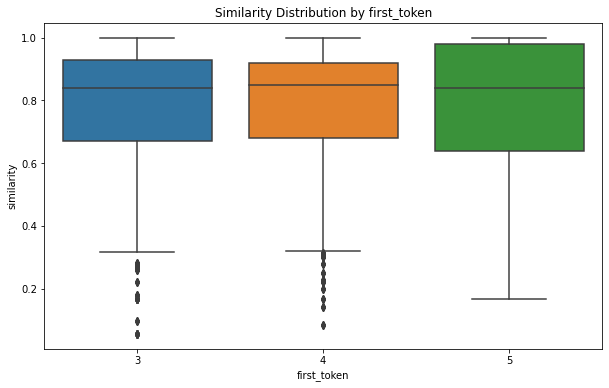


ANOVA results:
F-statistic: 0.1647268173353937
p-value: 0.8481330337805266

Tukey's HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3      4  -0.0023 0.9553 -0.0209 0.0163  False
     3      5   0.0073 0.9029 -0.0326 0.0472  False
     4      5   0.0096 0.8439  -0.031 0.0502  False
---------------------------------------------------

t-test results (first_token=5 vs others):
t-statistic: 0.49653487009755953
p-value: 0.6195534469741335

Cohen's d (effect size): 0.038069032994750195


In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with columns 'similarity' and 'first_token'

def analyze_similarity(df):
    # 1. Descriptive statistics
    print(df.groupby('first_token')['similarity'].describe())

    # 2. Visualization
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='first_token', y='similarity', data=df)
    plt.title('Similarity Distribution by first_token')
    plt.show()

    # 3. Statistical tests
    # ANOVA
    groups = [group for _, group in df.groupby('first_token')['similarity']]
    f_statistic, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA results:")
    print(f"F-statistic: {f_statistic}")
    print(f"p-value: {p_value}")

    # Post-hoc test (Tukey's HSD)
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey_results = pairwise_tukeyhsd(df['similarity'], df['first_token'])
    print("\nTukey's HSD results:")
    print(tukey_results)

    # 4. Comparing first_token=5 vs others
    similarity_5 = df[df['first_token'] == 5]['similarity']
    similarity_others = df[df['first_token'] != 5]['similarity']

    t_statistic, p_value = stats.ttest_ind(similarity_5, similarity_others)
    print("\nt-test results (first_token=5 vs others):")
    print(f"t-statistic: {t_statistic}")
    print(f"p-value: {p_value}")

    # Effect size (Cohen's d)
    mean_5 = np.mean(similarity_5)
    mean_others = np.mean(similarity_others)
    pooled_std = np.sqrt((np.std(similarity_5)**2 + np.std(similarity_others)**2) / 2)
    cohens_d = (mean_5 - mean_others) / pooled_std
    print(f"\nCohen's d (effect size): {cohens_d}")

# Run the analysis
analyze_similarity(df_cleaned)

## Preparing Data for Mechanistic Interpetability

For our studies in mech interp we want to compare pairs of prompts and discover the activations which are most different for a successful challenge vs an unsuccessful one.
To baseline this comparison we may also like to compare other close exmaples of success and failures.
These are hand selected after an exploration fo the data.


In [105]:
from IPython.display import display

# seeking unique rows, but not interested in task_id
df_clean = df_combined.drop(columns=['task_id'])
df_clean['target_len'] = df_clean['target'].apply(lambda x: len(x))

# get candidates for analysis
print("# 1. DEAD CERT! successful prompt (outcome=True), confidence is high, first_token=5")
a1 = df_clean[((df_clean['first_token'] == '5') & (df_clean['outcome'] == True))].sort_values(['filename'], ascending=True).drop_duplicates().sort_values(['target_len'], ascending=True).head(10)
display(a1)

print("## VS ##")

print("# 2. NEAR MISS. unsuccessful prompt (outcome=False), confidence is high, first_token=5")
a2 = df_clean[((df_clean['first_token'] == '5') & (df_clean['outcome'] == False) & (df_clean['similarity'] > 0.9))].drop_duplicates().sort_values(['target_len'], ascending=True).head(5)
display(a2)


# 1. DEAD CERT! successful prompt (outcome=True), confidence is high, first_token=5


,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome,target_len
106,5582e5ca.json,550,5,"[[8, 8, 8], [8, 8, 8], [8, 8, 8]]","[[8, 8, 8], [8, 8, 8], [8, 8, 8]]",1.0,True,33
1653,e9afcf9a.json,550,5,"[[6, 2, 6, 2, 6, 2], [2, 6, 2, 6, 2, 6]]","[[6, 2, 6, 2, 6, 2], [2, 6, 2, 6, 2, 6]]",1.0,True,40
1425,6d0aefbc.json,550,5,"[[6, 8, 6, 6, 8, 6], [8, 6, 8, 8, 6, 8], [1, 6...","[[6, 8, 6, 6, 8, 6], [8, 6, 8, 8, 6, 8], [1, 6...",1.0,True,60
1869,6fa7a44f.json,550,5,"[[2, 9, 2], [8, 5, 2], [2, 2, 8], [2, 2, 8], [...","[[2, 9, 2], [8, 5, 2], [2, 2, 8], [2, 2, 8], [...",1.0,True,66
1512,00576224.json,550,5,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...","[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...",1.0,True,120
1518,62c24649.json,550,5,"[[1, 1, 0, 0, 1, 1], [0, 3, 2, 2, 3, 0], [3, 3...","[[1, 1, 0, 0, 1, 1], [0, 3, 2, 2, 3, 0], [3, 3...",1.0,True,120
578,a416b8f3.json,550,5,"[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...","[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...",1.0,True,130
1803,dc433765.json,550,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",1.0,True,385


## VS ##
# 2. NEAR MISS. unsuccessful prompt (outcome=False), confidence is high, first_token=5


,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome,target_len
86,ba26e723.json,550,5,"[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 6, 0,...","[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4, 0,...",0.960784,False,159
376,855e0971.json,550,5,"[[8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]...","[[8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8]...",0.943137,False,799
198,91714a58.json,550,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.953125,False,800
336,e8dc4411.json,550,5,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...",0.979167,False,900
180,32597951.json,550,5,"[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...","[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...",0.972318,False,901


In [106]:
# get candidates for analysis

# 3. LUCKY STRIKE! successful prompt (outcome=True), confidence is low, first_token<5
# VS
# 4. KNOWN LOSER. unsuccessful prompt (outcome=False), confidence is low, first_token<5

print("# 1. LUCKY STRIKE! successful prompt (outcome=True), confidence is low, first_token<5")
b1 = df_clean[((df_clean['first_token'] !='5') & (df_clean['outcome'] == True))].sort_values(['filename'], ascending=True).drop_duplicates().sort_values(['target_len'], ascending=True).head(10)
display(a1)

print("## VS ##")

print("# 2. KNOWN LOSER. unsuccessful prompt (outcome=False), confidence is low, first_token<5")
b2 = df_clean[((df_clean['first_token'] != '5') & (df_clean['outcome'] == False) & (df_clean['similarity'] > 0.5) & (df_clean['similarity'] < 0.8))].drop_duplicates().sort_values(['target_len'], ascending=True).head(5)
display(a2)


# 1. LUCKY STRIKE! successful prompt (outcome=True), confidence is low, first_token<5


,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome,target_len
106,5582e5ca.json,550,5,"[[8, 8, 8], [8, 8, 8], [8, 8, 8]]","[[8, 8, 8], [8, 8, 8], [8, 8, 8]]",1.0,True,33
1653,e9afcf9a.json,550,5,"[[6, 2, 6, 2, 6, 2], [2, 6, 2, 6, 2, 6]]","[[6, 2, 6, 2, 6, 2], [2, 6, 2, 6, 2, 6]]",1.0,True,40
1425,6d0aefbc.json,550,5,"[[6, 8, 6, 6, 8, 6], [8, 6, 8, 8, 6, 8], [1, 6...","[[6, 8, 6, 6, 8, 6], [8, 6, 8, 8, 6, 8], [1, 6...",1.0,True,60
1869,6fa7a44f.json,550,5,"[[2, 9, 2], [8, 5, 2], [2, 2, 8], [2, 2, 8], [...","[[2, 9, 2], [8, 5, 2], [2, 2, 8], [2, 2, 8], [...",1.0,True,66
1512,00576224.json,550,5,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...","[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3...",1.0,True,120
1518,62c24649.json,550,5,"[[1, 1, 0, 0, 1, 1], [0, 3, 2, 2, 3, 0], [3, 3...","[[1, 1, 0, 0, 1, 1], [0, 3, 2, 2, 3, 0], [3, 3...",1.0,True,120
578,a416b8f3.json,550,5,"[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...","[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...",1.0,True,130
1803,dc433765.json,550,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",1.0,True,385


## VS ##
# 2. KNOWN LOSER. unsuccessful prompt (outcome=False), confidence is low, first_token<5


,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome,target_len
86,ba26e723.json,550,5,"[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 6, 0,...","[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4, 0,...",0.960784,False,159
376,855e0971.json,550,5,"[[8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]...","[[8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8]...",0.943137,False,799
198,91714a58.json,550,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.953125,False,800
336,e8dc4411.json,550,5,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...",0.979167,False,900
180,32597951.json,550,5,"[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...","[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...",0.972318,False,901


In [119]:
# Hand picked, all short prompt.
# 1. Dead Cert
# 2. Near Miss
# 3. Lucky Strike
# 4. Known loser

selected_df = pd.concat([
                a1[(a1['filename']=='a416b8f3.json') & (a1['prompt_len']==550)], 
                a2[(a2['filename']=='ba26e723.json') & (a2['prompt_len']==550)], 
                b1[(b1['filename']=='d037b0a7.json') & (b1['prompt_len']==550)], 
                b2[(b2['filename']=='48d8fb45.json') & (b2['prompt_len']==550)]]
)
selected_df

,filename,prompt_len,first_token,prediction_extracted,target,similarity,outcome,target_len
578,a416b8f3.json,550,5,"[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...","[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...",1.000000,True,130
86,ba26e723.json,550,5,"[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 6, 0,...","[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4, 0,...",0.960784,False,159
148,d037b0a7.json,550,3,"[[4, 0, 8], [4, 0, 8], [4, 7, 8]]","[[4, 0, 8], [4, 0, 8], [4, 7, 8]]",1.000000,True,33
154,48d8fb45.json,550,4,"[[0, 3, 3], [3, 3, 3], [3, 3, 0]]","[[0, 3, 0], [3, 3, 0], [0, 3, 3]]",0.555556,False,33


## Present Data for Use in Mechanistic Interpetibility Notebook

We will need a full prompt for each example, the target, filename, etc...

In [121]:
data_for_sae=[]

for index,row in selected_df.iterrows():
    training_data  = get_train(row['filename'])
    prompt_text = instructions_short + training_data
    gemma_row = {'filename':    row['filename'], 
                 'confidence':  row['first_token'], 
                 'len_prompt':  len(prompt_text), 
                 'prompt_text': prompt_text,
                 'target': row['target'],
                 'outcome': row['outcome']}
    data_for_sae.append(gemma_row)

data_for_sae = pd.DataFrame(data_for_sae)
data_for_sae

,filename,confidence,len_prompt,prompt_text,target,outcome
0,a416b8f3.json,5,1437,Below are pairs of matrices. \nThere is a mapp...,"[[4, 0, 0, 0, 4, 0, 0, 0], [4, 5, 0, 0, 4, 5, ...",True
1,ba26e723.json,5,2464,Below are pairs of matrices. \nThere is a mapp...,"[[0, 4, 0, 6, 0, 4, 0, 4, 0, 6, 0, 4, 0, 4, 0,...",False
2,d037b0a7.json,3,1179,Below are pairs of matrices. \nThere is a mapp...,"[[4, 0, 8], [4, 0, 8], [4, 7, 8]]",True
3,48d8fb45.json,4,2531,Below are pairs of matrices. \nThere is a mapp...,"[[0, 3, 0], [3, 3, 0], [0, 3, 3]]",False


In [122]:
# Save to file
data_for_sae.to_parquet('data_for_sae.parquet')

# Example How To Use Data in Interpretibility Notebook


In [82]:
# Read a file from your Google Drive
import json
import pandas as pd
from pathlib import Path
from datasets import Dataset
from transformer_lens.utils import tokenize_and_concatenate
import pandas as pd
from datasets import Dataset

source = 'data_for_sae.parquet'

# Read the parquet file from your Google Drive
df = pd.read_parquet(source)

# exclude the long prompt records for now
df = df[df['prompt_type']!='LongPrompt']

# Function to create a dataset from our dataframe
def create_dataset(main_col, filename_col, dataframe):
    return Dataset.from_pandas(dataframe[[main_col, filename_col]])

# Create datasets
prompt_dataset = create_dataset('prompt_text', 'filename', df)
target_dataset = create_dataset('target', 'filename', df)


# Example of how to access the data
print(prompt_dataset[0])  # This will show both 'prompt_text' and 'filename' for the first item
print(target_dataset[0])  # This will show both 'target' and 'filename' for the first item

# If you need to get all filenames
all_filenames = prompt_dataset['filename']

# If you need to get the filename for a specific index
index = 5
filename_for_index = prompt_dataset[index]['filename']
prompt_for_index = prompt_dataset[index]['prompt_text']
print(f"Filename for index {index}: {filename_for_index}")
print(f"Prompt for index {index}: {prompt_for_index}")

{'prompt_text': 'TRAIN Pair 0\nINPUT. Shape=(2, 2)\narray([[8, 6],\n       [6, 4]])\nOUTPUT. Shape=(6, 6)\narray([[8, 6, 8, 6, 8, 6],\n       [6, 4, 6, 4, 6, 4],\n       [6, 8, 6, 8, 6, 8],\n       [4, 6, 4, 6, 4, 6],\n       [8, 6, 8, 6, 8, 6],\n       [6, 4, 6, 4, 6, 4]])\n=============\nTRAIN Pair 1\nINPUT. Shape=(2, 2)\narray([[7, 9],\n       [4, 3]])\nOUTPUT. Shape=(6, 6)\narray([[7, 9, 7, 9, 7, 9],\n       [4, 3, 4, 3, 4, 3],\n       [9, 7, 9, 7, 9, 7],\n       [3, 4, 3, 4, 3, 4],\n       [7, 9, 7, 9, 7, 9],\n       [4, 3, 4, 3, 4, 3]])\n=============\nTEST Pair 0\nINPUT. Shape=(2, 2)\narray([[3, 2],\n       [7, 8]])\nOUTPUT. ', 'filename': '00576224.json', '__index_level_0__': 0}
{'target': 'OUTPUT. Shape=(6, 6)\narray([[3, 2, 3, 2, 3, 2],\n       [7, 8, 7, 8, 7, 8],\n       [2, 3, 2, 3, 2, 3],\n       [8, 7, 8, 7, 8, 7],\n       [3, 2, 3, 2, 3, 2],\n       [7, 8, 7, 8, 7, 8]])', 'filename': '00576224.json', '__index_level_0__': 0}
Filename for index 5: 239be575.json
Prompt for 